# Masking function to only keep ice-free ocean grid boxes

The NAWDEX ICON runs used sstice_mode=1. This means, according to the namelist description "Namelist_overview.pdf":
 
1: SST and sea ice fraction are read from the analysis. The SST is kept constant whereas the sea ice fraction can be modified by the seaice model.

We therefore here construct a mask for open ocean, i.e., ocean grid points that at no point in time during the simulation are covered by sea ice. This mask is then stored in a netcdf file for later use. Because the sea ice fraction depends on the simulation, there is one mask for each simulation.

The mask is 1 for open ocean points, and 0 otherwise.

Because the boundaries of the simulation domain are affected by nudging and not all fields are meaningfully defined there, we also set the mask to zero in the boundary zone. The nudging zone depends on the resolution, and is larger for coarser resolutions. The boundary cutoff is chosen such that it is large enough to fit the 80 km resolution, implying that it is large enough for the finer resolutions as well. The analysis box covers 31N-72N and 64W-25E.

**The first part** of the script shows the calculation on the example of a singel 80km simulation. **The second part** loops over many simulations and employs a simple locak dask cluster to speed up the simulation.

Aiko Voigt, KIT, 5.8.2020

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

Set up dask

In [2]:
from dask.distributed import Client
client = Client()
client

/pf/b/b380459/conda-envs/Nawdex-Hackathon/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32949 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:35922 Dashboard: http://127.0.0.1:32949/status,Cluster Workers: 8 Cores: 48 Memory: 134.22 GB


In [3]:
import sys
sys.path.append('/pf/b/b380459/nawdex-hackathon/shared')

import dict_nawdexsims
simdict = dict_nawdexsims.simdictionary()

## Part 0: Load data function needed for both part 1 and 2

Load sea ice fraction, land fraction and grid information data

In [16]:
def load_data(expid, gridres):
    
    dict_gridres={'80km': 'R80000m', '40km': 'R40000m', '20km': 'R20000m',
                  '10km': 'R10000m', '5km': 'R5000m', '2km': 'R2500m'}
    gridres=dict_gridres[gridres]
    
    # sea-ice fraction
    path  = '/scratch/b/b380459/icon_4_hackathon/'
    fname = path+'/'+expid+'/'+expid+'_2016*_fg_DOM01_ML_0*.nc'
    ds_fr_seaice = ( xr.open_mfdataset(fname, combine='by_coords',parallel=True, 
                                       engine='h5netcdf', chunks={'time': 1})[['fr_seaice']].rename({'ncells_2': 'ncells'}) )
    
    # get land-sea mask from extpar data
    path  = '/work/bb1018/icon_4_hackathon/'
    fname = path+'/extpar/extpar_icon-grid_nawdex_78w40e23n80n_'+gridres+'_bitmap.nc'
    ds_fr_land = xr.open_dataset(fname)['FR_LAND'].rename({'cell': 'ncells'})
    
    # grid dataset
    path  = '/work/bb1018/icon_4_hackathon/'
    fname = path+'/grids/icon-grid_nawdex_78w40e23n80n_'+gridres+'.nc'
    ds_grid = ( xr.open_dataset(fname)
                [['clat','clon']].rename({'cell': 'ncells'}) ) 
    
    # merge dataset
    ds = xr.merge([ds_fr_seaice, ds_fr_land, ds_grid])
    
    return ds

## Part 1: example for 80 km simulation

In [18]:
ds = load_data('nawdexnwp-80km-mis-0001', '80km')

### Set openocean mask to 1.0 where the sum of land fraction and the time maximum of sea ice fraction does not exceed 0

These are ocean points that at no point in time are covered by sea ice.

In [19]:
openocean = xr.where((ds['FR_LAND']+ds['fr_seaice'].max('time'))==0, 1, 0)  

### Now also cut off boundary zone: set openocean to zero outside of there 31N-72N and 64W-25E

In [20]:
openocean = xr.where(np.rad2deg(ds.clat)>+72, 0, openocean)
openocean = xr.where(np.rad2deg(ds.clat)<+31, 0, openocean)
openocean = xr.where(np.rad2deg(ds.clon)<-64, 0, openocean)
openocean = xr.where(np.rad2deg(ds.clon)>+25, 0, openocean)

### Plot to check that openocean looks fine

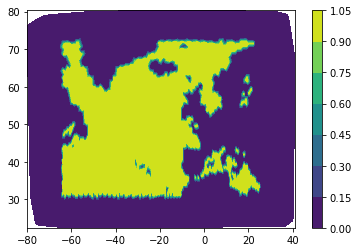

In [21]:
plt.tricontourf(np.rad2deg(ds.clon), np.rad2deg(ds.clat), openocean);
plt.colorbar()

### Set metadata of openocean 

In [22]:
openocean.name = 'mask_openocean'
openocean.attrs['description'] = '1: ocean grid cells with no ice at any time step1; 0: otherwise'
openocean.attrs['simulation'] = 'nawdexnwp-80km-mis-0001'

## Part 2: now we loop over many simulations and resolutions to compute the openocean mask and store to to disk

In [23]:
def make_openoceanmask(simid, gridres):
    
    ds = load_data(simid, gridres)
    
    openocean = xr.where((ds['FR_LAND']+ds['fr_seaice'].max('time'))==0, 1, 0)
    openocean = xr.where(np.rad2deg(ds.clat)>+72, 0, openocean)
    openocean = xr.where(np.rad2deg(ds.clat)<+31, 0, openocean)
    openocean = xr.where(np.rad2deg(ds.clon)<-64, 0, openocean)
    openocean = xr.where(np.rad2deg(ds.clon)>+25, 0, openocean)
    
    openocean.name = 'mask_openocean'
    openocean.attrs['description'] = '1: ocean grid cells with no ice at any time step1; 0: otherwise'
    openocean.attrs['simulation'] = simid
    
    openocean.to_netcdf('/work/bb1018/nawdex-hackathon_pp/openoceanmask/'+simid+'_openoceanmask.nc', mode='w')

In [24]:
for simid in list(simdict.keys()): 
    gridres = (simdict[simid])['res']
    print('Working on openocean mask for', simid, 'with resolution', gridres)
    make_openoceanmask(simid, gridres)    

Working on openocean mask for nawdexnwp-80km-mis-0001 with resolution 80km
Working on openocean mask for nawdexnwp-80km-mis-0002 with resolution 80km
Working on openocean mask for nawdexnwp-80km-mis-0003 with resolution 80km
Working on openocean mask for nawdexnwp-80km-mis-0004 with resolution 80km
Working on openocean mask for nawdexnwp-80km-mis-0005 with resolution 80km
Working on openocean mask for nawdexnwp-80km-mis-0006 with resolution 80km
Working on openocean mask for nawdexnwp-80km-mis-0007 with resolution 80km
Working on openocean mask for nawdexnwp-80km-mis-0008 with resolution 80km
Working on openocean mask for nawdexnwp-80km-mis-0009 with resolution 80km
Working on openocean mask for nawdexnwp-80km-mis-0010 with resolution 80km
Working on openocean mask for nawdexnwp-40km-mis-0001 with resolution 40km
Working on openocean mask for nawdexnwp-40km-mis-0002 with resolution 40km
Working on openocean mask for nawdexnwp-40km-mis-0003 with resolution 40km
Working on openocean mask

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-40km-mis-0008 with resolution 40km
Working on openocean mask for nawdexnwp-40km-mis-0009 with resolution 40km
Working on openocean mask for nawdexnwp-40km-mis-0010 with resolution 40km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-20km-mis-0001 with resolution 20km
Working on openocean mask for nawdexnwp-20km-mis-0002 with resolution 20km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-20km-mis-0003 with resolution 20km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-20km-mis-0004 with resolution 20km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-20km-mis-0005 with resolution 20km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-20km-mis-0006 with resolution 20km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-20km-mis-0007 with resolution 20km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-20km-mis-0008 with resolution 20km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-20km-mis-0009 with resolution 20km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-20km-mis-0010 with resolution 20km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0001 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0002 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0003 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0004 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0005 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0006 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0007 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0008 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0009 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0010 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0011 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-10km-mis-0012 with resolution 10km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0001 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0002 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0003 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0004 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0005 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0006 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0007 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0008 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0009 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0010 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0011 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-5km-mis-0012 with resolution 5km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0001 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0002 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0003 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0004 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0005 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0006 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0007 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0008 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0009 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0010 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0011 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0012 with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0001-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0002-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0005-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0006-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0007-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0008-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0009-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0010-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0011-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Working on openocean mask for nawdexnwp-2km-mis-0012-shcon with resolution 2km


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


## Clean up and properly shut down dask client

In [25]:
client.shutdown()
client.close()